In [8]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys
print(sys.version)

3.7.9 (default, Oct 18 2020, 22:55:02) 
[Clang 10.0.1 (clang-1001.0.46.4)]


In [22]:
import os
import pickle

import numpy as np
import torch
from matplotlib import pyplot as plt

In [12]:
torch.manual_seed(0);

## Loading the dataset

In [17]:
DATA_ROOT = "data/pop_pickle"

In [19]:
sequences = []
for i in range(1, 910):
    file_name = str(i).zfill(3) + ".pickle"
    path = os.path.join(DATA_ROOT, file_name)
    with open(path, "rb") as f:
        seq = pickle.load(f)
    sequences.append(seq)

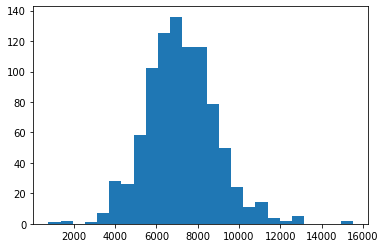

In [24]:
seq_lens = [len(seq) for seq in sequences]

plt.figure()
plt.hist(seq_lens, bins=25)
plt.show()

In [6]:
x = pickle.load(open("data/pop_pickle/001.pickle", "rb"))

In [7]:
type(x)

list